<a href="https://colab.research.google.com/github/Sirabhop/Kaggle_Challenges/blob/master/Challenge_1_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Titanic: Machine Learning from Disaster**

The question is who gonna survive from shipwreak? from those features I can draw 3 assumption


1. **The number of sibling, children, & parent** are effected the chance of survive because the titanic passenger would do ever it take to save their relatives.
2. **The room** where passenger stayed affected too, the chance of survival may depend on how easy for them to acquire the emergency boat.
3. **The status of their ticket**, one who are VIP guest on board may thought the crew cabin would rushed out to help them instead of economics passengers.
4. **Embarkation** may determined their belongings which increase time to escape





###**Import Data**

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns

from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier

import os

In [76]:
os.chdir("/content/drive/My Drive/My Project/Kaggle/Challenge#1_Titanic")

In [77]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


###**Data Exploration**

####**Categorical features**

**Passenger  ticket**
![alt text](https://drive.google.com/uc?export=view&id=1l1VjKlR4mBE1D5Gd7xEN1HPeuU1aESQC)

In [79]:
df[['Pclass', 'Survived']].groupby(['Pclass']).mean().sort_values(by = 'Survived')

,Survived
Pclass,
3,0.242363
2,0.472826
1,0.629630


![Sea lanes of Titanic](https://drive.google.com/uc?export=view&id=1DLHzbthFAdZboIGqbsKPm5utA-PB8MSL)

the route start from Southampton (UK) > Cherbourg (FR) > Queenstown (IR)


In [80]:
df[['Embarked', 'Survived']].groupby(['Embarked']).mean().sort_values(by = 'Survived')

,Survived
Embarked,
S,0.336957
Q,0.389610
C,0.553571


In [81]:
df[['Sex', 'Survived']].groupby(['Sex']).mean().sort_values(by = 'Survived')

,Survived
Sex,
male,0.188908
female,0.742038


In [82]:
df[['SibSp', 'Survived']].groupby(['SibSp']).mean().sort_values(by = 'Survived', ascending = False)

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [83]:
df[['Parch', 'Survived']].groupby(['Parch']).mean().sort_values(by = 'Survived', ascending = False)

,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000


####**Numerical features**

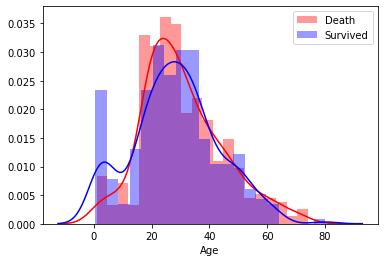

In [84]:
sns.distplot(df['Age'][df['Survived']==0], bins = 20, color = 'red', label = 'Death')
sns.distplot(df['Age'][df['Survived']==1], bins = 20, color = 'blue', label = 'Survived')
plt.legend()

plt.show()

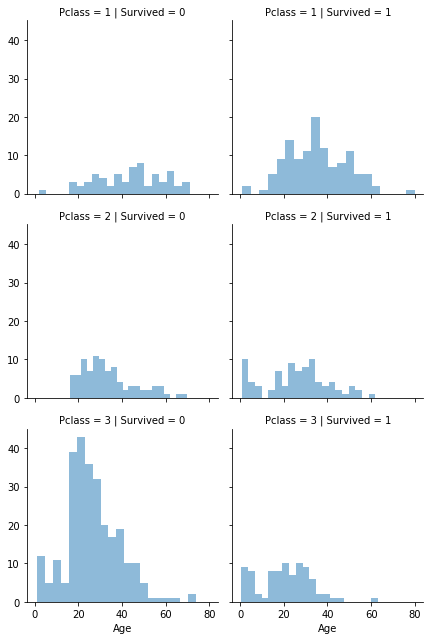

In [85]:
grid = sns.FacetGrid(df, col = 'Survived', row = 'Pclass')
grid.map(plt.hist, 'Age', alpha = 0.5, bins = 20)
grid.add_legend()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:723: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:728: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


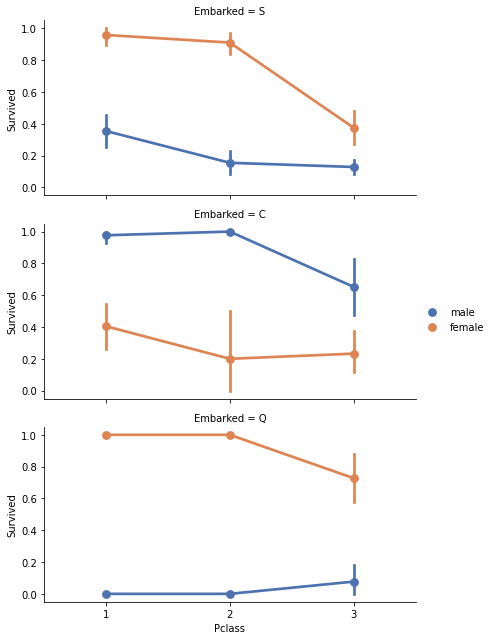

In [86]:
grid = sns.FacetGrid(df, row = 'Embarked', aspect = 2)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette = 'deep')
grid.add_legend()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


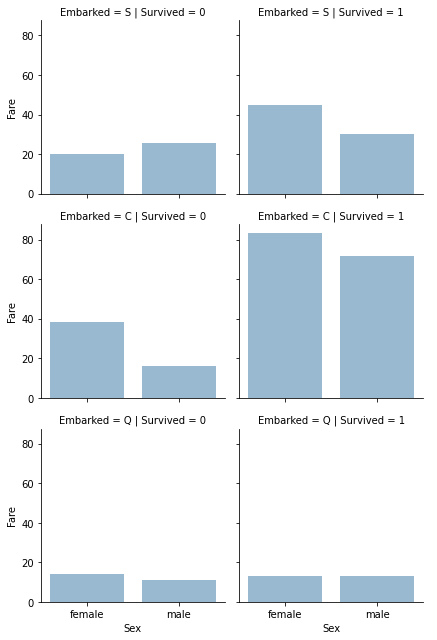

In [87]:
grid = sns.FacetGrid(df, row = 'Embarked', col = 'Survived')
grid.map(sns.barplot, 'Sex', 'Fare', alpha = 0.5, ci = None)
grid.add_legend()

###**Data Cleansing**

####**1) Extract the name**

In [88]:
combine = [df, test]
for dataset in combine:
  dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand = False)

In [89]:
pd.crosstab(df['Title'], df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [90]:
for dataset in combine:
  dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 
                                               'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
  dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
  dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
  dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [91]:
df[['Title', 'Survived']].groupby(['Title'], as_index = False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [92]:
title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}

for dataset in combine:
  dataset['Title'] = dataset['Title'].map(title_mapping)
  dataset['Title'] = dataset['Title'].fillna(0)

####**2) Sex Labeling**

In [96]:
df.drop(['Ticket', 'Cabin', 'Name', 'PassengerId'], axis = 1, inplace = True)
test.drop(['Ticket', 'Cabin', 'Name'], axis = 1, inplace = True)  

In [97]:
for dataset in combine:
  dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male': 0}).astype(int)

####**3) Age Band**

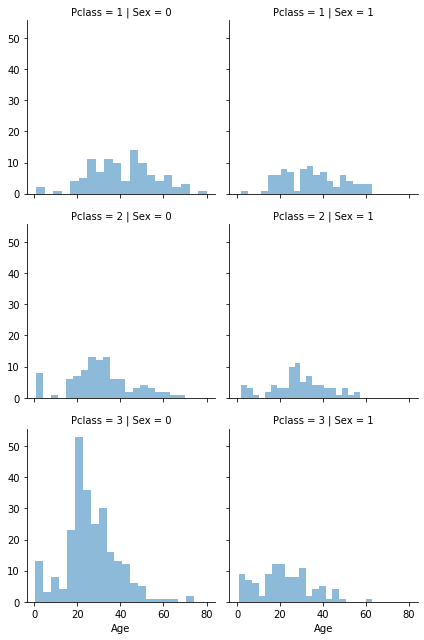

In [98]:
grid = sns.FacetGrid(df, row = 'Pclass', col = 'Sex')
grid.map(plt.hist, 'Age', alpha = 0.5, bins = 20)

In [99]:
guess_ages = np.zeros((2,3))

In [100]:
for dataset in combine:
  for i in range(0, 2):
    for j in range(0, 3):
      guess_df = dataset[(dataset['Sex'] == i) & 
                           (dataset['Pclass'] == j+1)]['Age'].dropna()
      age_med = guess_df.median()
      guess_ages[i, j] = int((age_med/0.5) + 0.5)*0.5

  for i in range(0, 2):
    for j in range(0, 3):
      dataset.loc[(dataset.Age.isnull()) & (dataset.Sex == i) & 
                  (dataset.Pclass == j+1), 'Age'] = guess_ages[i, j]
  
  dataset['Age'] = dataset['Age'].astype(int)

df.head()            

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


In [101]:
df['Ageband'] = pd.cut(df['Age'], 5)
df[['Ageband', 'Survived']].groupby(['Ageband'], as_index = False).mean().sort_values(by = 'Ageband', ascending = True)

,Ageband,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [102]:
for dataset in combine:
  dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
  dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
  dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 1
  dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 1
  dataset.loc[(dataset['Age'] > 64) & (dataset['Age'] <= 80), 'Age'] = 1

df.drop(['Ageband'], axis = 1, inplace = True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,1,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,1,1,0,53.1000,S,3
4,0,3,0,1,0,0,8.0500,S,1


###**Feature Engineering**

In [103]:
#Family Size

combine = [df, test]
for dataset in combine:
  dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1 #self

df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index = False).mean().sort_values(by = 'Survived', ascending = True)

,FamilySize,Survived
7,8,0.000000
8,11,0.000000
5,6,0.136364
4,5,0.200000
0,1,0.303538
6,7,0.333333
1,2,0.552795
2,3,0.578431
3,4,0.724138


In [104]:
#Lonely trip?

for dataset in combine:
  dataset['Alone'] = 0
  dataset.loc[dataset['FamilySize'] == 1, 'Alone'] = 1

df[['Alone', 'Survived']].groupby(['Alone'], as_index = False).mean()

,Alone,Survived
0,0,0.505650
1,1,0.303538


In [105]:
df.drop(['Parch', 'SibSp', 'FamilySize'], axis = 1, inplace = True)
test.drop(['Parch', 'SibSp', 'FamilySize'], axis = 1, inplace = True)

combine = [df, test]

In [106]:
#Fill Missing Value

freq_port = df.Embarked.dropna().mode()[0]

for dataset in combine:
  dataset['Embarked'].fillna(freq_port, inplace = True)

df[['Embarked', 'Survived']].groupby(['Embarked'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [107]:
#Embarked Label Encoding

for dataset in combine:
  dataset['Embarked'].replace({'S': 0, 'C': 1, 'Q': 2}, inplace = True)

In [108]:
#Fare 

Fare_med = pd.concat([df['Fare'], test['Fare']], axis = 0, ignore_index = True).median()

for dataset in combine:
  dataset['Fare'].fillna(Fare_med, inplace = True)

df['FareBand'] = pd.qcut(df['Fare'], 4)
df[['FareBand', 'Survived']].groupby(['FareBand'], as_index = False).mean().sort_values(by = 'FareBand', ascending = True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [109]:
for dataset in combine:
  dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
  dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
  dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
  dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
  dataset['Fare'] = dataset['Fare'].astype(int)

In [110]:
df = df.drop(['FareBand'], axis=1)
combine = [df, test]

In [111]:
df

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Alone
0,0,3,0,1,0,0,1,0
1,1,1,1,1,3,1,3,0
2,1,3,1,1,1,0,2,1
3,1,1,1,1,3,0,3,0
4,0,3,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...
886,0,2,0,1,1,0,5,1
887,1,1,1,1,2,0,2,1
888,0,3,1,1,2,0,2,0
889,1,1,0,1,2,1,1,1


###**Data Modeling**

In [112]:
X = df.drop(['Survived'], axis = 1)
y = df['Survived'].copy()

In [113]:
parameters = {'criterion': ('gini', 'entropy'),
              'max_depth': [2, 3, 4, 5, 6]}
dt = DecisionTreeClassifier()
clf = GridSearchCV(dt, parameters)
clf.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ('gini', 'entropy'),
                

In [114]:
clf.best_params_

{'criterion': 'entropy', 'max_depth': 3}

In [119]:
kf = KFold(n_splits = 5, shuffle = True)
clf = DecisionTreeClassifier('entropy', max_depth = 3)
cross_val_score(clf, X, y, cv = 10)

array([0.8       , 0.82022472, 0.74157303, 0.86516854, 0.82022472,
       0.79775281, 0.79775281, 0.76404494, 0.84269663, 0.83146067])

In [123]:
clf.fit(X, y)
prediction = clf.predict(test.iloc[:, 1:8])

In [137]:
output = pd.DataFrame(test['PassengerId'].copy())
output['Survived'] = prediction

In [138]:
output

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,0
415,1307,0
416,1308,0


In [139]:
output.to_csv('titanic#2.csv', index = False)